In [7]:
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=0.9)


=== DATASET: MMLU ===


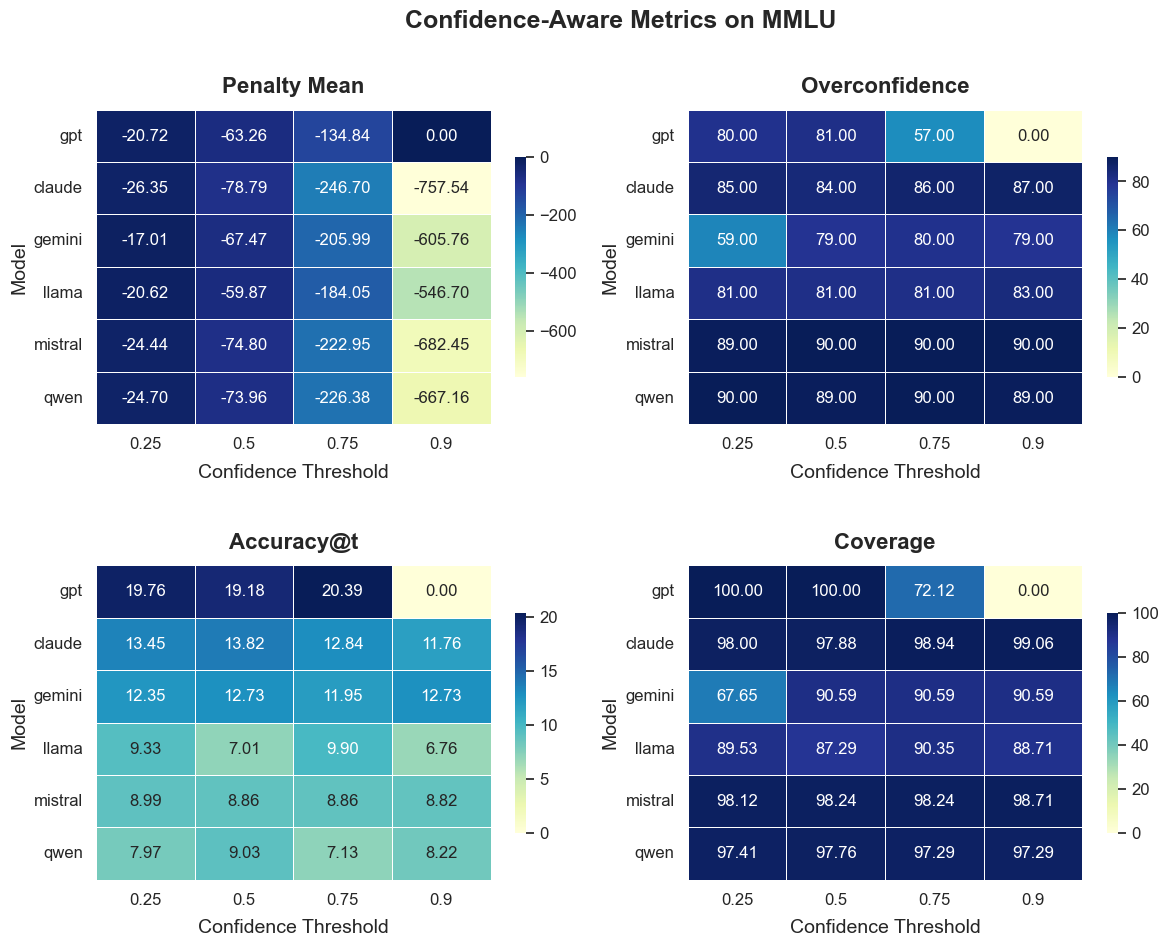


=== DATASET: GPQA ===


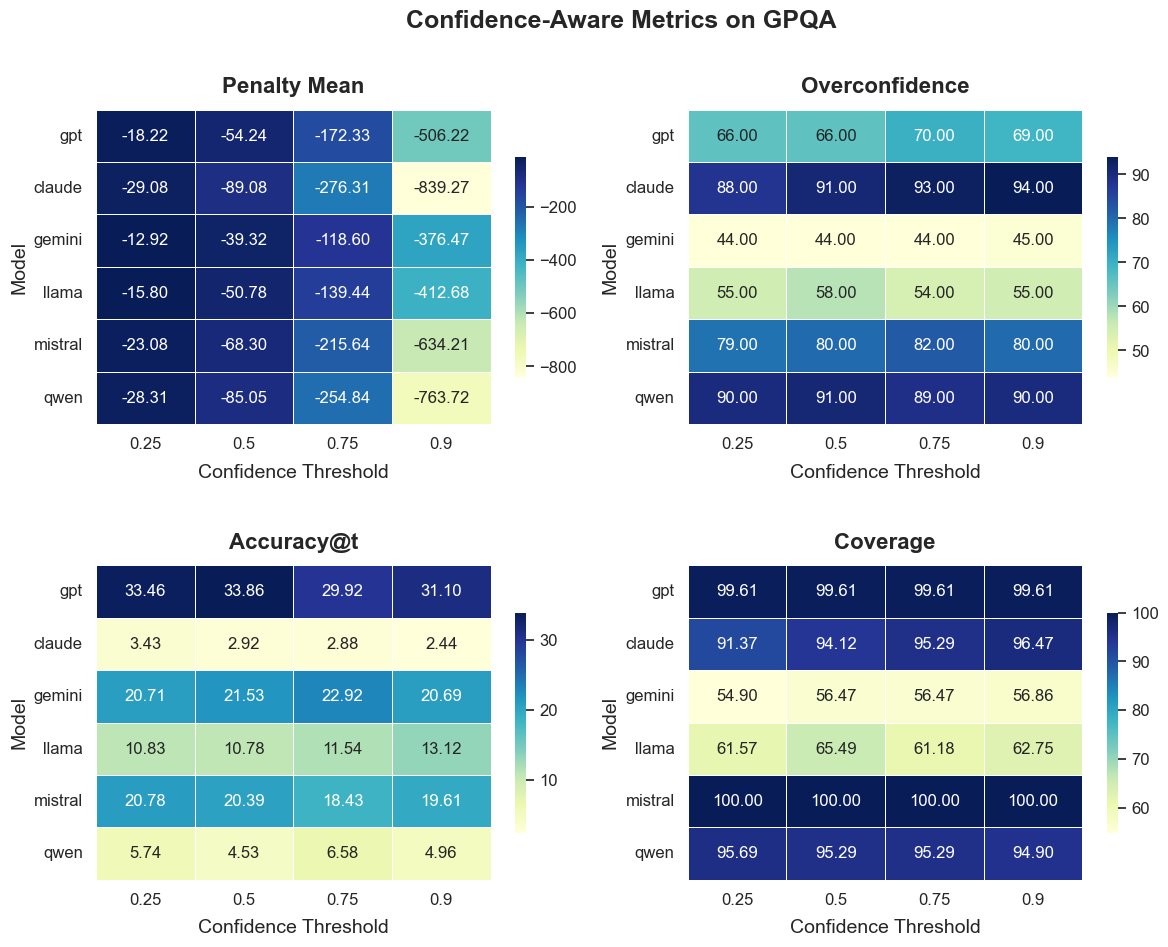

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "outputs"  # directory with metric CSVs

METRICS = [
    ("penalty_mean",  "Penalty Mean"),
    ("overconf_rate", "Overconfidence"),
    ("accuracy_at_t", "Accuracy@t"),
    ("coverage",      "Coverage"),
]

MODEL_ORDER = ["gpt", "claude", "gemini", "llama", "mistral", "qwen"]


def parse_filename(fname):
    """Return (model, dataset) from a filename like 'claude-gpqa-metric-eval.csv'."""
    base = os.path.basename(fname).replace(".csv", "")
    parts = base.split("-")
    if len(parts) < 4:
        raise ValueError(f"Unexpected file pattern: {fname}")
    model, dataset = parts[0], parts[1]
    return model, dataset


def load_metric_files(data_dir):
    """Load metric CSVs into a nested dictionary."""
    files = glob.glob(os.path.join(data_dir, "*-metric-eval.csv"))
    data = {}

    for f in files:
        model, dataset = parse_filename(f)
        df = pd.read_csv(f).sort_values("threshold").reset_index(drop=True)
        data.setdefault(dataset, {})
        data[dataset][model] = df

    return data


def order_models(model_list):
    """Order model names using MODEL_ORDER, then any extras alphabetically."""
    out = []
    remaining = set(model_list)

    for m in MODEL_ORDER:
        if m in remaining:
            out.append(m)
            remaining.remove(m)

    out.extend(sorted(remaining))
    return out


def plot_dataset_heatmaps(dataset, model_tables):
    """Plot a 2×2 heatmap panel for one dataset."""
    models = order_models(list(model_tables.keys()))
    thresholds = sorted(list(model_tables[models[0]]["threshold"].unique()))
    nt = len(thresholds)
    nm = len(models)

    metric_ranges = {}
    for metric, _ in METRICS:
        vals = []
        for m in models:
            vals.extend(model_tables[m][metric].dropna().tolist())
        metric_ranges[metric] = (min(vals), max(vals))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (metric, title) in zip(axes, METRICS):
        mat = np.full((nm, nt), np.nan, dtype=float)

        for i, model in enumerate(models):
            df = model_tables[model]
            df_map = dict(zip(df["threshold"], df[metric]))
            for j, t in enumerate(thresholds):
                mat[i, j] = df_map.get(t, np.nan)

        data_df = pd.DataFrame(mat, index=models, columns=thresholds)
        vmin, vmax = metric_ranges[metric]

        hm = sns.heatmap(
            data_df,
            ax=ax,
            annot=True,
            fmt=".2f",
            annot_kws={"size": 12},
            cmap="YlGnBu",
            vmin=vmin,
            vmax=vmax,
            cbar_kws={"shrink": 0.7},
            linewidths=0.5,
            linecolor="white",
            square=False,
        )

        ax.set_title(title, fontsize=16, fontweight="bold", pad=12)
        ax.set_xlabel("Confidence Threshold", labelpad=8, fontsize=14)
        ax.set_ylabel("Model", fontsize=14)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

        cbar = hm.collections[0].colorbar
        if cbar is not None:
            cbar.ax.tick_params(labelsize=12)

    fig.suptitle(
        f"Confidence-Aware Metrics on {dataset.upper()}",
        fontsize=18,
        fontweight="bold",
        y=0.98,
    )
    fig.subplots_adjust(hspace=0.45, top=0.88)
    plt.show()


# Run plots for each dataset
data = load_metric_files(DATA_DIR)

for dataset, model_tables in data.items():
    print(f"\n=== DATASET: {dataset.upper()} ===")
    plot_dataset_heatmaps(dataset, model_tables)
